
# 0) Importe Libreries

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# 1) Importe Datasets
## a) Extract and clean datasets

In [8]:
def extract_database(filename):
    df = pd.read_csv(filename)

    # Table of people
    df_p = df.drop_duplicates('iid').set_index('iid').loc[:, 'age':'amb3_1']
    df_p.loc[:, 'attr1_1':'amb3_1'] = df.loc[:, 'attr1_1':'amb3_1'].replace(to_replace=pd.NaT, value=0.0)
    df_p = df_p.drop("mn_sat", axis=1)
    df_p = df_p.drop("undergra", axis=1)
    df_p = df_p.drop("tuition", axis=1)
    df_p = df_p.drop("from", axis=1)
    df_p = df_p.drop("zipcode", axis=1)
    df_p = df_p.drop("income", axis=1)
    df_p = df_p.drop("field", axis=1)
    df_p = df_p.drop("field_cd", axis=1)
    df_p = df_p.drop("career", axis=1)
    df_p = df_p.drop("attr4_1", axis=1)
    df_p = df_p.drop("sinc4_1", axis=1)
    df_p = df_p.drop("intel4_1", axis=1)
    df_p = df_p.drop("fun4_1", axis=1)
    df_p = df_p.drop("amb4_1", axis=1)
    df_p = df_p.drop("shar4_1", axis=1)
    df_p = df_p.dropna(axis=0)

    # Table of meeting and result
    df_m = df.loc[:, ['iid', 'pid', 'match']]
    df_m = df_m[df_m["iid"].isin(list(df_p.index.values))]
    df_m = df_m[df_m["pid"].isin(list(df_p.index.values))]
    df_m = df_m.reset_index(drop=True)

    return df_p, df_m 

## b) Normalize datasets

In [3]:
class Normalizer:
    def __init__(self, training_array):
        self.__mini = np.min(training_array, axis=0)
        maxi = np.max(training_array, axis=0)
        self.__delta = maxi - self.__mini

    def __call__(self, array):
        return np.apply_along_axis(lambda x : (x-self.__mini)/self.__delta, 1, array)

## c) Reduce datasets

In [4]:
class PCA:
    def get_projection_matrix(self, array, n):
        corr = np.cov(array, rowvar=False)
        v, w = np.linalg.eig(corr)
        
        index = np.argsort(v)[::-1]
        return w[:, index[:n]]
    
    def __init__(self, training_array, n):
        self.__proj = self.get_projection_matrix(training_array, n)

    def __call__(self, array):
        return self.__proj.T.dot(array.T).T

## d) Piping and processing

Preprocess, PCA and Normalizer instances containts values that are related to the model, they have to be saved for future use in production !

In [5]:
class Preprocess:
    def __init__(self, df, dim):
        self.__df = df
        self.__norm = Normalizer(self.__df.values)
        self.__red = PCA(self.__norm(self.__df.values), dim)

    def __call__(self, iid):
        return self.__red(self.__norm(self.__df.loc[iid, :].values))

In [6]:
PEOPLE_DIM = 10
HIDDEN = 32
BATCH_SIZE = 60
EPOCHS = 10000

In [9]:
df_p, df_m = extract_database("Speed Dating Data.csv")

In [8]:
red = Preprocess(df_p.loc[:, 'attr1_1':'amb3_1'], PEOPLE_DIM)
blue = Preprocess(df_p.loc[:, 'date':'yoga'], PEOPLE_DIM)
vectorize = lambda x : np.concatenate((red(x), blue(x)), axis=1)

In [9]:
# Batches generator, provide random batches of given size
def gen_profile():
    gen = df_m.sample(frac=1).reset_index().iterrows()
    for j in range(EPOCHS):
        iid, pid, match = [], [], []
        for i in range(BATCH_SIZE):
            try:
                row = next(gen)[1]
            except StopIteration:
                gen = df_m.sample(frac=1).reset_index().iterrows()
                row = next(gen)[1]
            iid.append(int(row.loc['iid']))
            pid.append(int(row.loc['pid']))
            match.append(row.loc['match'])
        
        yield np.float32(match).reshape([BATCH_SIZE, 1]), vectorize(iid), vectorize(pid)

# 2) Model definition
The Goal of this model isn't to predict a probaility of finding someone. This model take two users profile as input to predict if they can matche each other. Because those inputs are mutable, the model have to be symetric to be realy efficient.

In [10]:
# Placeholders
iid_ph = tf.placeholder(np.float32, shape=[None, PEOPLE_DIM*2])
pid_ph = tf.placeholder(np.float32, shape=[None, PEOPLE_DIM*2])
match_ph = tf.placeholder(np.float32, shape=[None, 1])

# Model
cont_ab = tf.concat_v2((iid_ph, pid_ph), axis=1)
cont_ba = tf.concat_v2((pid_ph, iid_ph), axis=1)

w_1 = tf.Variable(tf.truncated_normal([PEOPLE_DIM*4, HIDDEN], stddev=0.1))
b_1 = tf.Variable(tf.truncated_normal([HIDDEN], stddev=0.1))
l_h_ab = tf.nn.softplus(tf.matmul(cont_ab, w_1) + b_1)
l_h_ba = tf.nn.softplus(tf.matmul(cont_ba, w_1) + b_1)

w_2 = tf.Variable(tf.truncated_normal([HIDDEN, 1], stddev=0.1))
b_2 = tf.Variable(tf.truncated_normal([1], stddev=0.1))
l_2 = tf.matmul(l_h_ab, w_2) + tf.matmul(l_h_ba, w_2) + b_2
logits = tf.sigmoid(l_2)

# Trainer
print("Total vars: ~{:.2f}k\n".format((4*PEOPLE_DIM*HIDDEN + 2*HIDDEN + 1)/1000))
global_step = tf.Variable(0, trainable=False)
learing_rate = tf.train.exponential_decay(0.1, global_step, 1000, 0.8, staircase=True)
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=l_2, targets=match_ph))
trainer_step = tf.train.MomentumOptimizer(learing_rate, 0.9).minimize(loss, global_step=global_step)

Total vars: ~1.34k



# 3) Processing
Burn Baby, Burn (some GPUs). Training and lookup table computation.

In [11]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()

    # Train the model
    print("Training...")
    i = 0
    for profile in gen_profile():
        trainer_step.run(feed_dict={iid_ph: profile[1], pid_ph: profile[2], match_ph: profile[0]})

        if i % 1000 == 0:
            print(loss.eval(feed_dict={iid_ph: profile[1], pid_ph: profile[2], match_ph: profile[0]}))
        i += 1
    print("\n")

    # Let's find love <3
    # It fill a lookup table, it's not the goal, but it's useful to dispay results
    print("Looking for hope...")
    l_df_p = len(df_p)
    mp = np.ndarray((l_df_p, l_df_p), dtype=np.float32)  # Map of result
    for i in range(l_df_p):
        pid = df_p.index[i]
        for j in range(l_df_p):
            iid = df_p.index[j]
            mp[i, j] = logits.eval(feed_dict={iid_ph: vectorize([iid]), pid_ph: vectorize([pid])})[0, 0]
    print("Done")


Training...
0.431305
0.410977
0.327745
0.325008
0.195164
0.191231
0.35098
0.18574
0.292437
0.174357


Looking for hope...


# 3) Test Model

In [12]:
# Model Testing
def find(i):
    n = 0
    for j in list(df_p.index):
        if i==j:
            return n
        n += 1
        
error = 0.0
for index, rows in df_m.iterrows():
    error += abs(rows["match"] - mp[find(rows["iid"]), find(rows["pid"])])
print("Avg error: {:.2f}%".format(100 * error / len(df_m)))

Avg error: 9.46%


# 4) Data Visualisation

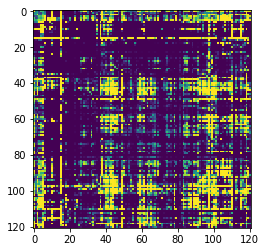

In [14]:
# Display the Love map
plt.imshow(mp)
plt.show()